We will use the typical dataset SQuAD for the Question Answering task. The format in SQuAD is given a question and a passage of text containing the answer, BERT will highlight the span that contains the correct answer.

To feed a QA task into BERT, we pack both the question and reference text into the input. Those two parts are separated by a [SEP] token. In addition, BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are two embeddings BERT has learned and will be added to the token embeddings before pass into input layer.

BERT highlight the span of correct answer in the reference text by predicting which token marks as the start of the answer and which token marks the end.

For every token in the text, we feed the final embedding into a start token classifier. The start token classifier only has a single set of weights which is applies to every word. We take the dot product between the output embeddings and start token classifier weight and apply a softmax layer to get a probability distribution over all words and we take the word with highest probability as the word to start in the answer.

And we repeat this process for the end token with end token weights.

In [2]:
import torch
from dask.array.chunk import argmax

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/zhangqiduan/anaconda3/envs/CS682_Final_Proj/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import BertForQuestionAnswering, BertTokenizer

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

/Users/zhangqiduan/anaconda3/envs/CS682_Final_Proj/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
question = "How many parameters does BERT-large have?"

answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [6]:
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens'.format(len(input_ids)))

The input has a total of 70 tokens


In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token, id in zip(tokens, input_ids):
    print('{:}\t{:}'.format(id, token))

101	[CLS]
2129	how
2116	many
11709	parameters
2515	does
14324	bert
1011	-
2312	large
2031	have
1029	?
102	[SEP]
14324	bert
1011	-
2312	large
2003	is
2428	really
2502	big
1012	.
1012	.
1012	.
2009	it
2038	has
2484	24
1011	-
9014	layers
1998	and
2019	an
7861	em
8270	##bed
4667	##ding
2946	size
1997	of
1015	1
1010	,
6185	02
2549	##4
1010	,
2005	for
1037	a
2561	total
1997	of
16029	340
2213	##m
11709	parameters
999	!
10462	altogether
2009	it
2003	is
1015	1
1012	.
4090	34
18259	##gb
1010	,
2061	so
5987	expect
2009	it
2000	to
2202	take
1037	a
3232	couple
2781	minutes
2000	to
8816	download
2000	to
2115	your
15270	cola
2497	##b
6013	instance
1012	.
102	[SEP]


In [10]:
sep_index = input_ids.index(tokenizer.sep_token_id)

num_seg_a = sep_index + 1

num_seg_b = len(input_ids) - num_seg_a

segment_ids = [0] * num_seg_a + [1] * num_seg_b

assert len(input_ids) == len(segment_ids)

In [11]:
outputs = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]), return_dict=True)



In [17]:
start_score = outputs.start_logits
end_score = outputs.end_logits

In [24]:
answer_start = torch.argmax(start_score)
answer_end = torch.argmax(end_score)

answer = ''.join(tokens[answer_start:answer_end+1])
print('Answer:', answer)

Answer: 340##m


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (16, 8)


In [41]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_score.detach().numpy().flatten()
e_scores = end_score.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

/var/folders/pt/q9vwsl4x40d6ps5bbrylx_j80000gn/T/ipykernel_96267/1402920714.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
/var/folders/pt/q9vwsl4x40d6ps5bbrylx_j80000gn/T/ipykernel_96267/1402920714.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


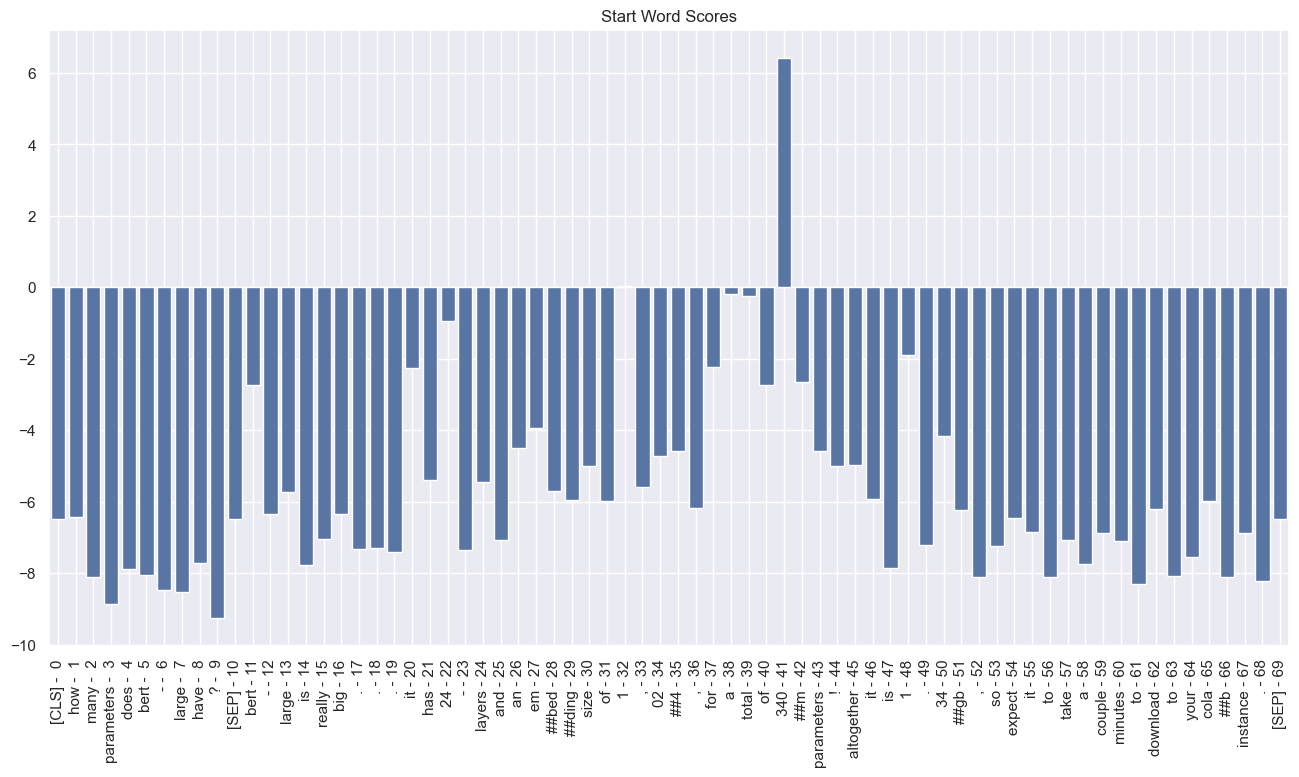

In [43]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

/var/folders/pt/q9vwsl4x40d6ps5bbrylx_j80000gn/T/ipykernel_96267/2498766993.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
/var/folders/pt/q9vwsl4x40d6ps5bbrylx_j80000gn/T/ipykernel_96267/2498766993.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


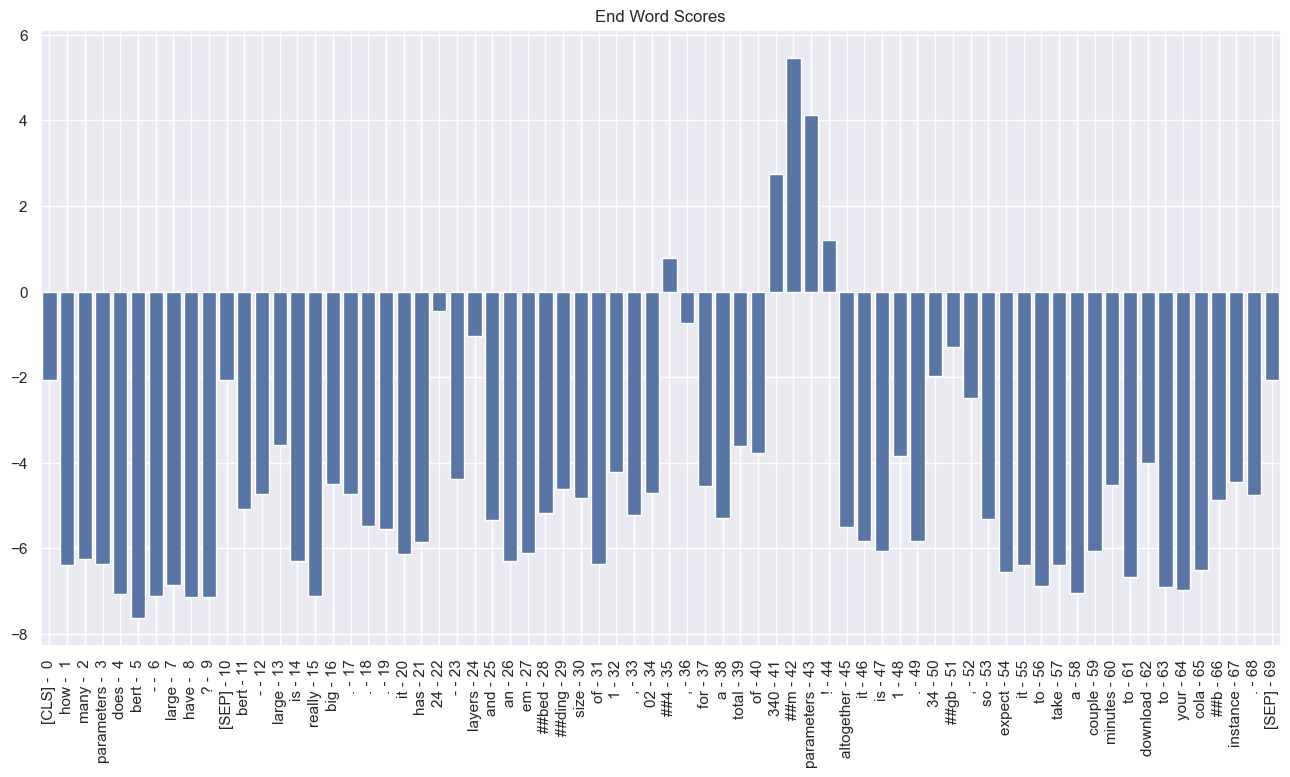

In [44]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()